### Instructions

When running the notebook the first time, make sure to run all cells before making changes in the notebook. Hit Shift + Enter to run the selected cell or, in the top menu, click on: `Kernel` > `Restart & Run All` > `Restart and Run All Cells` to rerun the whole notebook. If you make any changes in a cell, rerun that cell.

In [1]:
# Import dependencies
import sys
sys.path.append('python/')        # Define path
import time
startTime = time.time()           # Calculate time for running this notebook
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import ipywidgets as w
from matplotlib.widgets import RadioButtons
import load_galaxies as lg        # Load load_galaxies.py library

# Rotation Curve Plotting

There are three steps of the rotation curve building process: <br>
1. Plotting the measured velocity data
2. Constructing the rotation curves for each component
3. Fitting the total velocity to the measured values 

The following notebook explores the first and **the second step** of the process by walking you through the method of **building a rotation curve** for each component of the galaxy of your choice. The rotation of the bulge, disk and gas were traced from a scientific journal (Noordermeer 2008) for galaxy NGC 5533, or were imported from the Spitzer Photometry & Accurate Rotation Curves (SPARC) database for galaxies NGC 5005, NGC 7814, and NGC 891. These rotational velocities were derived from luminosities, surface brightness, and surface mass densities. However, the calculation is beyond the scope of this workshop. On the contrary, theoretical curves can also be obtained using empirically derived parameters, instead of full profiles. <br>

_Insight: As a bonus in this workshop, the calculation for the theoretical curve of the bulge is introduced  in notebook 07\_Bonus\_Bulge\_Rotation\_Curve.ipynb_. <br>

For this activity, you will calculate the rotation curve for the Dark Matter using an isothermal density profile and its two free parameters, central core density ($\rho_0$) and radius ($r_c$). As a final exercise, you will also plot the rotation curve with its total velocities and all of its components, and modify some of the parameters to experiment with the curve.

![A poster. The header reads, "CHOOSE: WHICH GALAXY". Below are four boxes, each contianing a galaxy name, an image of said galaxy, and some stats about the galaxy. The options are: NGC 5005, AKA Caldwell 29, Distance: 45 MLY, Size: 55,000 LY, Constellation: Canes Venatici; NGC 5533, An Unbarred Spiral Galaxy, Distance: 177 MLY, Size: 50,000 LY, Constellation: Bootes; NGC 7814, A Bulge-Dominant Galaxy, Distance: 40 MLY, Size: 80,000 LY, Constellation: Pegasus; and NGC 891, A Disk-Dominant Galaxy, Distance: 27.3 MLY, Size: 120,000 LY, Constellation: Andromeda.](images/chooseWhichGalaxy.jpg)

<div class="alert-info">Activity 1)</div>

>Choose your galaxy: Enter `galaxy = lg.GALAXYNAME` below to select your galaxy.

In [2]:
galaxy = lg.NGC5005          # Options: lg.NGC5005 , lg.NGC5533 , lg.NGC7814 , lg.NGC0891

### Import measured radial velocity data of the chosen galaxy

In [3]:
# Measured data
measured_data = galaxy['measured_data']

# Separate the columns of the data into arrays
m_radii = galaxy['m_radii']           # Radius
m_velocities = galaxy['m_velocities'] # Velocity
m_v_errors = galaxy['m_v_errors']     # Errors in velocity         

### Import the light matter components

The structure of a galaxy can be separated into individual components based on their shape to simplify the process of producing a galactic rotation curve. <br>

The bulge and disk are two stellar components of spiral galaxies. The less dense disk is made from the spiral arms and the bulge is the dense spherical core of the galaxy. The mass of these components is estimated using their luminosities, then given a mass-to-light ratio. The variation in the mass-to-light ratio means there is a wider range of masses that are plausible for the stellar components.

The gas is distributed somewhat evenly throughout the galaxy's disk and is composed of mainly Hydrogen. The gas's composition is determined by using light emissions spectra to identify the elements present. The element’s known molecular mass is used to calculate the gas components mass with higher accuracy. For this reason, gas rotation curves are often plotted with the gas parameters fixed, and they are multiplied by 1.33 to account for helium. 

Note: the following data has been interpolated or 'splined' using `scipy.interpolate.BSpline`, which means the data points has been connected and turned into a function. Below, we have called these variables as functions of radius at selected points. For example: `bulge_v(r)`, `disk_v(r)`, `gas(r)`, etc.

In [4]:
# Bulge spline
bulge_v = galaxy['bulge']['spline']   
# Disk spline
disk_v = galaxy['disk']['spline']
# Gas spline
gas_v = galaxy['gas']['spline']

### For NGC 5533 ONLY: Calculate central supermassive black hole component

**Note: If you chose a galaxy other than NGC 5533, you can proceed to the section titled 'Calculate Dark Matter Halo Component' .** <br>
Calculate the central black hole component for galaxy NGC 5533. The other galaxies have their black hole component included with their bulge, which scientific publications may do depending on the focus of their research. For example: In a two-component model, only the halo and disk are plotted (Casertano, 1983). In the case of NGC 7814, the bulge curve that is used in these calculations includes the possible black hole. (Note that this is not specified in the article (Fraternali, Sancisi, and Kamphuis 2011) but is suggested in the NASA website: https://www.nasa.gov/feature/goddard/caldwell-43.) <br>

Due to the extreme mass and negligible radius, a central supermassive black hole is represented as a point value and the rotation curve can be calculated using the orbital velocity of a point-mass (mass is not a function of radius in this case). 
>__Rotational velocity due to central supermassive black hole__: <br>
\begin{equation}
v_{BH} = \sqrt\frac{GM_{BH}}{r}
\end{equation}
<br>
>where:<br>
        $G$ = gravitational constant<br>
        $M_{BH}$ = mass of central supermassive black hole<br>
        $r$ = radius or distance from the center of the galaxy
    <br>

<div class="alert-info">Activity 2)</div>

>Modify the radius value while keeping the mass of the black hole fixed to see how it affects the velocity of the stars and gas. Use an estimate for the black hole’s mass.

<div class="alert-info">Activity 3)</div>

>Based on the values measured, how might the black hole component be affecting the galaxy's rotational velocity?

<div class="alert-info">Activity 4)</div>

>Change the mass of the black hole at a fixed radius to see how it affects the velocity of stars and gas. <br>

_Python help: Change the value of the mass of the black hole by changing the value for massbh. For example: `massbh = 3e10`_

In [5]:
# Set Parameters
massbh = galaxy['massbh']        # Mass of the central black hole in (solar mass) imported from our Python library
radius = 10                      # Radius to calculate velocity due to black hole component (in kpc)
G = 4.300e-6                     # Gravitational constant (kpc/solar mass*(km/s)^2)

# Display the mass of the black hole
if massbh != 0:
    print("Mass of the central supermassive black hole at the center of the galaxy {}: {:.3e} solar masses".format(galaxy['galaxyname'],massbh))

# Equation for point-mass rotation curve
def blackhole_v(r,massbh):
    return np.sqrt((G*massbh)/r)

# Displaying the value of the velocity of stars and gas at a chosen radius
if massbh == 0:
    print("Galaxy {} might have a central supermassive black hole but it is included in the bulge curve.".format(galaxy['galaxyname']))
if massbh != 0:
    print("Radial velocity at r={}[kpc]: {:.3f} km/s".format(radius,blackhole_v(radius,massbh)))

Galaxy NGC 5005 might have a central supermassive black hole but it is included in the bulge curve.


### Calculate Dark Matter Halo Component

The Isothermal Density Profile is used to model the structure of the Dark Matter halo. It takes two parameters, central core radius ($r_c$) and central core density ($\rho_0$). The density profile is used to find the enclosed mass, which is then used to determine the rotational velocity defined by the parameters $\rho_0$ and $r_c$ and evaluated for the best fit. (Jimenez et al. 2003). <br>

>__Isothermal Density Profile__: <br>
    \begin{equation}
    \rho(r) = \rho_{0}\left[1+{\left(\frac{r}{r_c}\right)}^{2}\right]^{-1}
    \end{equation}
    <br>
>where:<br>
    $\rho_{0}$ = core density<br>
    $r_c$ = core radius<br>
    $r$ = radius 
    
>__Enclosed Mass__: <br>
    \begin{equation}
    M_{DM}(r) = \int_{0}^{r} 4\pi\rho(r^{\prime})r^{\prime 2}d r^{\prime}
    \end{equation}<br>
>where:<br>
        $M_{DM}$ = mass of the dark matter halo<br>
        $\rho(r)$ = density profile
    <br>
    
>__Rotational Velocity__: <br>
    \begin{equation}
    v_{DM}^{2}(r) = \frac{GM_{DM}(r)}{r}
    \end{equation}<br>
    \begin{equation}
    v_{DM}(r) = \sqrt{4 \pi G \rho_{0} r_c^2 \big( 1- \frac{r_c}{r} \arctan{\frac{r}{r_c}}\big)}
    \end{equation}<br>
>where:<br>
        $G$ = gravitational constant<br>

<div class="alert-info">Activity 5)</div>

>Looking at the Isothermal Density Profile equation above, consider what happens to $\rho_0$ at large and small radii. How does the density change as we look further from the center? <br>
    
<div class="alert-info">Activity 6)</div>

>Change the value of the three variables `rho0` (for $\rho_0$) and `rc` (for $r_c$) and `radius`  in the next cell to see how the velocity of the dark matter changes at the selected radius.

In [6]:
# Set parameters
rho0 = galaxy['rho0']   # central mass density (in solar mass/kpc^3)
rc = galaxy['rc']       # core radius (in kpc)
radius = 10             # radius (in kpc)

# Display the two dark matter parameters
print("Dark matter halo parameters: ")
print("     Central mass density: {:.2e} solar mass/kpc^3".format(rho0))
print("     Core radius: {:.2f} kpc".format(rc))

# Equation for dark matter halo velocity
def halo_v(r,rho0,rc):
    v = np.sqrt(4*np.pi*G*rho0*rc**2*(1 - rc/r * np.arctan(r/rc)))
    return v

# Display the velocity at the selected radius
print("     Velocity at {} kpc: {:.3f} km/s".format(radius,halo_v(radius,rho0,rc)))

Dark matter halo parameters: 
     Central mass density: 1.69e+07 solar mass/kpc^3
     Core radius: 9.92 kpc
     Velocity at 10 kpc: 139.722 km/s


### Calculate total velocity

All components of the galaxy contribute to the rotation curve or the total velocity of stars and gas. This can be added quadratically in the following way:

>__Total velocity__: <br>
    \begin{equation}
    v_{total}(r) = \sqrt{v_{bulge}^2 + v_{disk}^2 + v_{gas}^2 + v_{blackhole}^2 + v_{dm\ halo}^2}
    \end{equation}<br>

### Scaling parameter (Mass-to-Light ratio)

The scaling parameter is analogous to the mass-to-light ratio (M/L) that indicates how much mass it is expected from the light source. Because the mass is a rough estimation, the mass-to-light ratio is a good free parameter to use for curve fitting (see _08\_Interactive\_Fitting.ipynb_ module). 

Suggestions on the scaling parameters: 
- NGC 891 : Notice that the disk and the bulge rotation curve is much higher than the measured velocity (data was imported from SPARC). This discrepancy can be later fixed by fitting these curves to the measured data points. For now, you may scale it down to 1/2 or 3/4. (i.e. `bpref = 0.75`, `dpref = 0.5`)
- NGC 7814 : Similar to NGC 891, the disk and bulge should be scaled down to align with the measured velocities well. (i.e. `bpref = 0.75`, `dpref = 0.8`)

<div class="alert-info">Activity 7)</div>

>Modify the total rotational velocity WITHOUT the Dark Matter component by changing the scaling parameters of each galaxy component. For example: if you want the contribution from the disk to the rotation curve to be doubled, change `dpref = 1` to `dpref = 2`.

_Python help: Rerun the notebook to see the changes in the graph by hitting Shift+Enter on both the cells or by clicking on the menu: `Kernel` > `Restart and Run All Cells...`._

In [20]:
# Scaling parameters
bpref = 0.75 #1      # Bulge 
dpref = 0.75 #1      # Disk
gpref = 1      # Gas
bhpref = 1     # Central supermassive black hole

In [21]:
# Total velocity WITHOUT dark matter halo component but with adjustable prefactors
def total_v_noDM(r,massbh):
    v = np.sqrt( (bpref * bulge_v(r))**2                   # bulge component + scaling parameter
               + (dpref * disk_v(r))**2                    # disk component + scaling parameter
               + (gpref * gas_v(r))**2                     # gas component + scaling parameter
               + (bhpref * blackhole_v(r,massbh))**2)      # central supermassive black hole component + scaling factor
    return v

<div class="alert-info">Activity 8)</div>

>Modify the total rotational velocity WITH the Dark Matter component by commenting out each galaxy component included in the _total_v_ function below to see how it affects the total rotation curve plotted at the end of the notebook. For example: remove the bulge by inserting a pound sign `#` before the term: `(bpref * bulge_v(r)**2`.<br>

In [22]:
# Total velocity WITH dark matter halo component
def total_v(r,massbh,rho0,rc):
    v = np.sqrt( 
        (bpref * bulge_v(r))**2                  # bulge component
        + (dpref * disk_v(r))**2                 # disk component
        + (gpref * gas_v(r))**2                  # gas component
        + (bhpref * blackhole_v(r,massbh))**2    # central black hole component (this might be zero for NGC 891, NGC 7814 and NGC 5005 but it is because it's included in the bulge velocity)
        + halo_v(r,rho0,rc)**2)                  # dark matter halo component
    return v

### Plot all components and total velocity

In the graph at the end of this notebook, notice the difference between the total velocity with the Dark Matter halo component (red) and without the Dark Matter halo component (yellow). <br><br>

<div class="alert-info">Activity 9)</div>

>Using the scaling parameters defined in Activty 7 above, are you able to scale the components of the total velocity without the Dark Matter component to match the curve of the measured data? Do these scaling parameters make sense or are they unreasonable? <br>

_Insight: In the activity 08\_Interactive\_Fitting.ipynb, you won't have to guess these scaling parameters. Instead, you will be able to "fit" all curves to the measured data points and see what these multipliers might be._

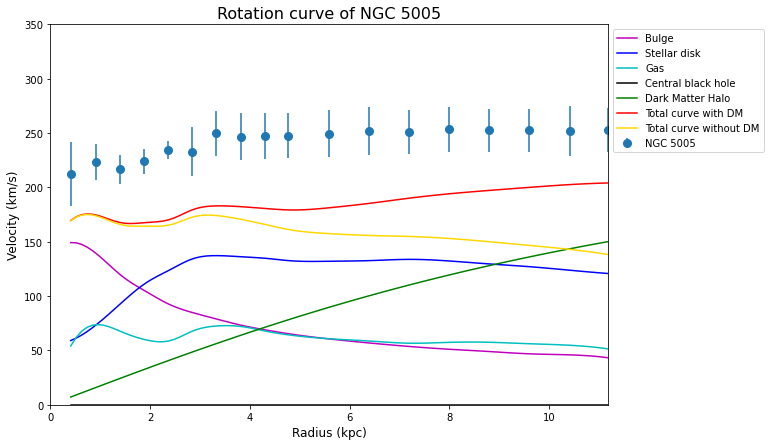

In [23]:
# Define radius for plotting
r_lowerlim = np.min(m_radii)                       # limit the radius to the min value of the measured radius
if r_lowerlim == 0:                                # getting rid of dividing by zero error
    r_lowerlim = 0.01
r_upperlim = np.max(m_radii)                       # limit the radius to the max value of the measured radius
r = np.linspace(r_lowerlim,r_upperlim,100)         # starting from zero results in a divide by zero error

# Plot 
plt.figure(figsize=(10.0,7.0))                     # size of the plot
plt.plot(r, bpref * bulge_v(r),            color='m', label='Bulge')
plt.plot(r, dpref * disk_v(r),             color='b', label='Stellar disk')                        
plt.plot(r, gpref * gas_v(r),              color='c', label='Gas')            
plt.plot(r, bhpref * blackhole_v(r,massbh), color='k', label='Central black hole')    # only for NGC 5533         
plt.plot(r, halo_v(r,rho0,rc),     color='g', label='Dark Matter Halo')   

plt.plot(r, total_v(r,massbh,rho0,rc), color='r',    label='Total curve with DM')
plt.plot(r, total_v_noDM(r,massbh),    color='gold', label='Total curve without DM')

plt.errorbar(m_radii, m_velocities, yerr=m_v_errors, 
             marker='o', markersize=8,
             linestyle='none', 
             label='{}'.format(galaxy['galaxyname']))

plt.title('Rotation curve of {}'.format(galaxy['galaxyname']), fontsize=16)     # giving the plot a title
plt.xlabel('Radius (kpc)', fontsize=12)                           # labeling the x-axis
plt.ylabel('Velocity (km/s)', fontsize=12)                        # labeling the y-axis
plt.xlim(0,r_upperlim)                                            # limits of the x-axis
plt.ylim(0,350)                                                   # limits of the y-axis
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [11]:
#NBVAL_IGNORE_OUTPUT
#Because the timing won't be exactly the same each time.
# Time
executionTime = (time.time() - startTime)
ttt = executionTime/60
print(f'Execution time: {ttt:.2f} minutes')

Execution time: 0.05 minutes


### References

>Casertano, Stefano. **Rotation curve of the edge-on spiral galaxy NGC 5907: disc and halo masses.** _Monthly Notices of the Royal Astronomical Society_ 203, no. 3 (1983): 735-747. https://doi.org/10.1093/mnras/203.3.735. <br><br>
>Fraternali, F., R. Sancisi, and P. Kamphuis. **A Tale of Two Galaxies: Light and Mass in NGC 891 and NGC 7814.** Astronomy &amp; Astrophysics 531 (June 13, 2011). https://doi.org/10.1051/0004-6361/201116634.<br><br> 
>Jimenez, Raul, Licia Verde, and S. Peng Oh. **Dark halo properties from rotation curves.** _Monthly Notices of the Royal Astronomical Society_ 339, no. 1 (2003): 243-259. https://doi.org/10.1046/j.1365-8711.2003.06165.x. <br><br>
>Kapteyn Institute. (n.d.). Groningen Image Processing System. **GIPSY, the GRONINGEN image processing system.** https://www.astro.rug.nl/~gipsy/index.html. <br><br>
>Karukes, E. V., P. Salucci, and Gianfranco Gentile. **The dark matter distribution in the spiral NGC 3198 out to 0.22 $R_{vir}$.** _Astronomy & Astrophysics_ 578 (2015): A13. https://doi.org/10.1051/0004-6361/201425339. <br><br>
>Noordermeer, Edo. **The rotation curves of flattened Sérsic bulges.** _Monthly Notices of the Royal Astronomical Society_ 385, no. 3 (2007): 1359-1364. https://doi.org/10.1111/j.1365-2966.2008.12837.x. <br><br>
>Richards, Emily E., L. van Zee, K. L. Barnes, S. Staudaher, D. A. Dale, T. T. Braun, D. C. Wavle, et al. **Baryonic Distributions in the Dark Matter Halo of NGC 5005.** Monthly Notices of the Royal Astronomical Society 449, no. 4 (June 1, 2015): 3981–96. https://doi.org/10.1093/mnras/stv568. 
***

### Images

>**NGC5005**: Based on observations made with the NASA/ESA Hubble Space Telescope, and obtained from the Hubble Legacy Archive, which is a collaboration between the Space Telescope Science Institute (STScI/NASA), the Space Telescope European Coordinating Facility (ST-ECF/ESA) and the Canadian Astronomy Data Centre (CADC/NRC/CSA).<br>
>**NGC5533**: Sloan Digital Sky Survey, DR14 with SciServer https://www.sdss.org/dr14/imaging/jpg-images-on-skyserver/<br>
>**NGC7814**: Adam Block/Mount Lemmon SkyCenter/University of Arizona http://www.caelumobservatory.com/gallery/n7814.shtml<br>
>**NGC891**: Adam Block/Mount Lemmon SkyCenter/University of Arizona https://apod.nasa.gov/apod/ap170112.html